In [32]:
import harmonica as hm
import numpy as np
import verde as vd
import xarray as xr
import magali as mg
import matplotlib.pyplot as plt

In [33]:

sensor_sample_distance = 5.0  # µm
coordinates = vd.grid_coordinates(
    region=[0, 2000, 0, 2000],  # µm
    spacing=2,  # µm
    extra_coords=sensor_sample_distance,
)

true_inclination = 30
true_declination = 40
true_dispersion_angle = 5


size = 100

directions_inclination, directions_declination = mg.random_directions(
    true_inclination,
    true_declination,
    true_dispersion_angle,
    size=size,
    random_state=5,
)

dipoles_amplitude = abs(np.random.normal(0, 100, size)) * 1.0e-14

dipole_coordinates = (
    np.concatenate([np.random.randint(30, 1970, size), [1250, 1300, 500]]),  # µm
    np.concatenate([np.random.randint(30, 1970, size), [500, 1750, 1000]]),  # µm
    np.concatenate([np.random.randint(-20, -1, size), [-15, -15, -30]]),  # µm
)
dipole_moments = hm.magnetic_angles_to_vec(
    inclination=np.concatenate([directions_inclination, [10, -10, -5]]),
    declination=np.concatenate([directions_declination, [10, 170, 190]]),
    intensity=np.concatenate([dipoles_amplitude, [5e-11, 5e-11, 5e-11]]),
)

data = mg.dipole_bz_grid(
    region, spacing, sensor_sample_distance, dipole_coordinates, dipole_moments
)
data

<xarray.DataArray 'bz' (y: 1001, x: 1001)> Size: 8MB
array([[ 4.08642675,  4.09068033,  4.09384244, ...,  6.63575141,
         6.57963546,  6.5238703 ],
       [ 4.0886906 ,  4.09086346,  4.09177823, ...,  6.70770859,
         6.6503883 ,  6.59343042],
       [ 4.08976252,  4.08967903,  4.08815278, ...,  6.78122772,
         6.7226586 ,  6.66446427],
       ...,
       [18.83280502, 19.10870215, 19.38799356, ...,  7.05089494,
         6.99788091,  6.94453127],
       [18.4739424 , 18.74058674, 19.01040764, ...,  6.91944525,
         6.86805909,  6.81635186],
       [18.12386023, 18.38161617, 18.64234512, ...,  6.79170954,
         6.74187908,  6.69174173]])
Coordinates:
  * x        (x) float64 8kB 0.0 2.0 4.0 6.0 ... 1.996e+03 1.998e+03 2e+03
  * y        (y) float64 8kB 0.0 2.0 4.0 6.0 ... 1.996e+03 1.998e+03 2e+03
    z        (y, x) float64 8MB 5.0 5.0 5.0 5.0 5.0 5.0 ... 5.0 5.0 5.0 5.0 5.0
Attributes:
    long_name:  vertical magnetic field
    units:      nT

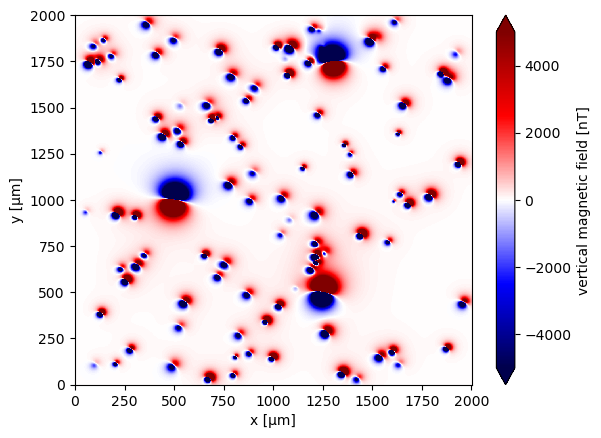

In [34]:
data.plot.pcolormesh(cmap="seismic", vmin=-5000, vmax=5000)

In [35]:
deriv_x = hm.derivative_easting(data)
deriv_y = hm.derivative_northing(data)

In [36]:
spacing = np.mean([np.abs(data.x[1] - data.x[0]), np.abs(data.y[1] - data.y[0])])

In [37]:
data_up = hm.upward_continuation(data, spacing).assign_coords(x=data.x, y=data.y)
data_down = hm.upward_continuation(data, -spacing).assign_coords(x=data.x, y=data.y)
deriv_z = (data_up - data_down) / (2 * spacing)

/home/yago/miniforge3/envs/magali/lib/python3.12/site-packages/xrft/xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
/home/yago/miniforge3/envs/magali/lib/python3.12/site-packages/xrft/xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)


In [38]:
tga = np.sqrt(deriv_x**2 + deriv_y**2 + deriv_z**2)

In [42]:
tga.attrs = {"long_name": "total gradient amplitude", "units": "nT/µm"}
deriv_x.attrs = {"long_name": "x-derivative", "units": "nT/µm"}
deriv_y.attrs = {"long_name": "y-derivative", "units": "nT/µm"}
deriv_z.attrs = {"long_name": "z-derivative", "units": "nT/µm"}

In [ ]:
data = xr.Dataset({"tga": tga, "x_deriv": deriv_x, "y_deriv": deriv_y, "z_deriv": deriv_z})

KeyError: 'tga'

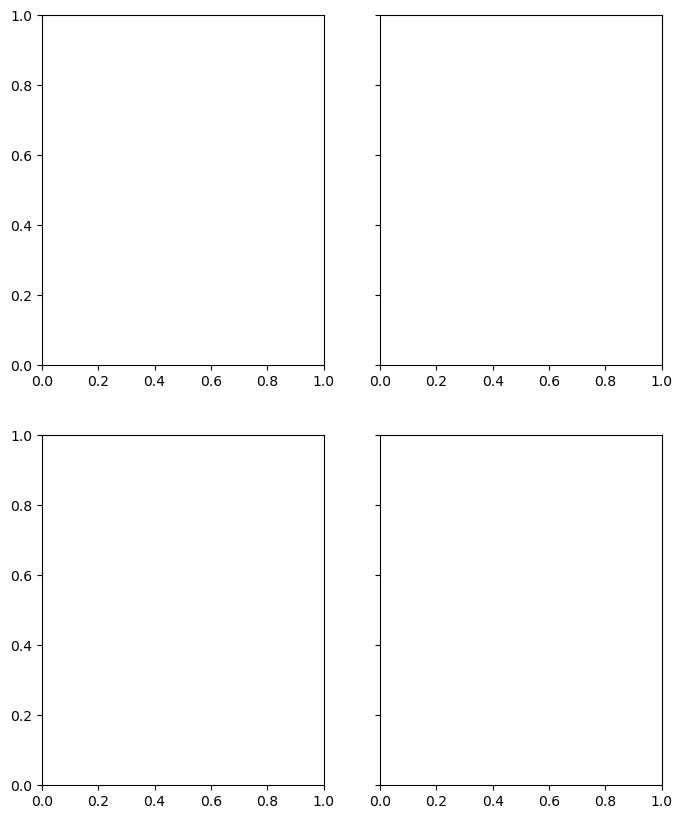

In [44]:
fig, axes = plt.subplots(2, 2, figsize=(8, 10), sharey="row")
cbar_kwargs = dict(orientation="horizontal", aspect=50, pad=0.15, shrink=0.5)
for field, ax in zip(["tga", "deriv_x", "deriv_y", "deriv_z"], axes.ravel()):
    if field == "tga":
        cmap = "plasma"
    else:
        cmap="seismic"
    data_up[field].plot.pcolormesh(ax=ax, cmap=cmap, cbar_kwargs=cbar_kwargs)
for ax in axes.ravel():
    ax.set_aspect("auto")
    
axes[0,1].set_ylabel(None)
axes[1,1].set_ylabel(None)
plt.tight_layout(pad=0, h_pad=0, w_pad=2)